In [1]:
import pandas as pd
import numpy as np
import torch
import pickle
import datetime
# dataloader
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

import sys
sys.path.append('../sys_model/')

from sys_model_dataset import  SysModelDataset

# Import pytorch_lightning model
import pytorch_lightning as pl
from system_model import SysModel

# make jupytre relode modules when they change
%load_ext autoreload
%autoreload 2

# Load dataset for getting pasts

In [2]:
# csv file path
sys_model_df = pd.read_csv('../../../../misc/recorded_data/tick_based_100hz_23-02-19.csv')

In [3]:
window_input_size = 30

evolve_iterations = 100

ar_dataset = SysModelDataset(
    df=sys_model_df,
    num_time_steps_before=window_input_size,
    num_time_steps_after=evolve_iterations
)

In [4]:
# Create dataloader
ar_dataloader = DataLoader(ar_dataset, batch_size=1, shuffle=True, num_workers=8)

# sys model

In [5]:
# load model
sys_model = SysModel(
    num_past_time_steps = 30,
    num_input_vars = 2,
    num_output_vars = 1,
    num_internal_vars = 2,
)
sys_model.load_state_dict(torch.load('../sys_model/sys_model_2023-03-03_15-33-21.pt'))

<All keys matched successfully>

# Optimal torque

In [6]:

# means and std of internal channels before normalization
internal_channel_means = [-2.0340237e+03, -2.1668540e+03]
internal_channel_stds = [1.1323308e+03, 1.2715853e+03]

In [7]:
optimal_torque_encoder_value_pre_norm = -900
optimal_torque_encoder_value = (optimal_torque_encoder_value_pre_norm - (-2.0340237e+03)) / 1.1323308e+03
optimal_torque_encoder_value

1.0014950578046626

# Calculate optimal future pwm
Calcualte the optimal future pwm to get as close to the desired future postion as possible while still maintaining the optimal torque.

In [8]:
def calc_optim_future_input(
        past_inputs,
        past_outputs,
        past_interals,
        future_desired_outputs,
        cost_threshold,
        max_iterations,
):
    # Init future inputs with zeros
    future_inputs = torch.zeros(past_inputs.shape[0], past_inputs.shape[1], future_desired_outputs.shape[2])

    sys_model.train()
    future_inputs.requires_grad = True

    outputs = torch.cat((past_outputs, torch.zeros(past_inputs.shape[0], past_outputs.shape[1], future_desired_outputs.shape[2])), dim=2)
    interals = torch.cat((past_interals, torch.zeros(past_inputs.shape[0], past_interals.shape[1], future_desired_outputs.shape[2])), dim=2)


    optimizer = torch.optim.SGD([future_inputs], lr=100, momentum=0.9)

    for ii in range(0, max_iterations):
        inputs = torch.cat((past_inputs, future_inputs), dim=2)

        # reset gradients
        optimizer.zero_grad()
        for i in sys_model.parameters():
            i.grad = None


        outputs_predicted = outputs.clone()
        interals_predicted = interals.clone()
        for i in range(0, inputs.shape[2]- window_input_size):
            # concatenate past and future to get the model input

            next_predicted_output, next_predicted_internal = sys_model(inputs[:, :, i:i+window_input_size], outputs_predicted[:, :, i:i+window_input_size], interals_predicted[:, :, i:i+window_input_size])
            outputs_predicted[:, :, i+window_input_size] = next_predicted_output[:,:,0]
            interals_predicted[:, :, i+window_input_size] = next_predicted_internal[:,:,0]


        future_infered_angle = outputs_predicted[:, 0, window_input_size:]
        future_infered_flex_myobrick_torque_encoder = interals_predicted[:, 0, window_input_size:]
        future_infered_extend_myobrick_torque_encoder = interals_predicted[:, 1, window_input_size:]

        # Calculate cost
        angle_loss = torch.mean((future_infered_angle - future_desired_outputs) ** 2)
        flex_torque_loss = torch.mean(torch.nn.functional.leaky_relu(future_infered_flex_myobrick_torque_encoder - optimal_torque_encoder_value, negative_slope=-0.05) ** 2)
        extend_torque_loss = torch.mean(torch.nn.functional.leaky_relu(future_infered_extend_myobrick_torque_encoder - optimal_torque_encoder_value, negative_slope=-0.05) ** 2)
        loss = 5 * angle_loss + flex_torque_loss + extend_torque_loss

        #print(loss)
        loss.backward()

        optimizer.step()

        # Clip future inputs to be between -3 and 3
        future_inputs.data.clamp_(-3, 3)

        if loss < cost_threshold:
            break


    future_optimized_inputs = future_inputs
    future_infered_outputs = outputs_predicted[:, :, window_input_size:]
    future_infered_interals = interals_predicted[:, :, window_input_size:]
    
    return future_optimized_inputs, future_infered_outputs, future_infered_interals

In [25]:
past_inputs, past_outputs, past_interals, future_inputs, future_outputs, future_interals = next(iter(ar_dataloader))
_, _, _, _, desired_future_outputs, _ = next(iter(ar_dataloader))


future_optimized_inputs, future_infered_outputs, future_infered_interals = calc_optim_future_input(
    past_inputs,
    past_outputs,
    past_interals,
    desired_future_outputs,
    cost_threshold=0.005,
    max_iterations=200,
)

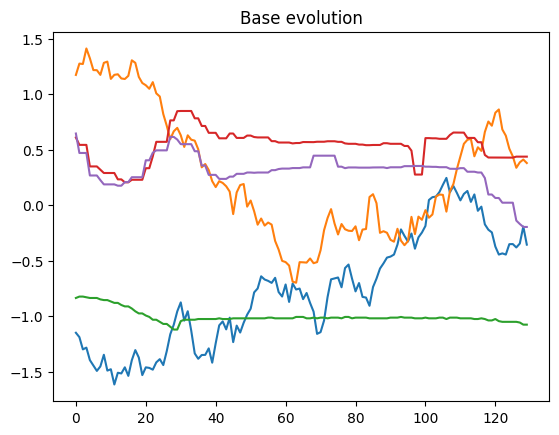

In [26]:
inputs = torch.cat((past_inputs, future_inputs), dim=2)
outputs = torch.cat((past_outputs, desired_future_outputs), dim=2)
interals = torch.cat((past_interals, future_interals), dim=2)

# Plot infered evolution
for i in range(inputs.shape[1]):
    plt.plot(inputs[0, i, :].detach().numpy())
for i in range(outputs.shape[1]):
    plt.plot(outputs[0, i, :].detach().numpy())
for i in range(interals.shape[1]):
    plt.plot(interals[0, i, :].detach().numpy())
plt.title('Base evolution')
plt.show()
# Add title

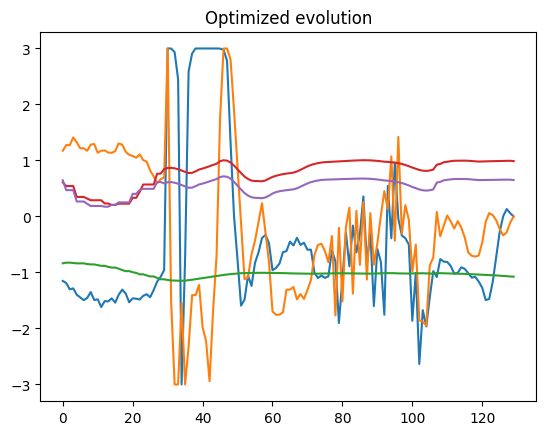

In [27]:
inputs = torch.cat((past_inputs, future_optimized_inputs), dim=2)
outputs = torch.cat((past_outputs, future_infered_outputs), dim=2)
interals = torch.cat((past_interals, future_infered_interals), dim=2)

# Plot infered evolution
for i in range(inputs.shape[1]):
    plt.plot(inputs[0, i, :].detach().numpy())
for i in range(outputs.shape[1]):
    plt.plot(outputs[0, i, :].detach().numpy())
for i in range(interals.shape[1]):
    plt.plot(interals[0, i, :].detach().numpy())
plt.title('Optimized evolution')
plt.show()
# Add title

# Generation of data pints

In [28]:
import db1
import time
import datetime

In [29]:
num_evolutions_to_generate = 10000

In [30]:
saved_evolutions = []

In [31]:
t_0 = time.time()
for i in range(num_evolutions_to_generate):
    past_inputs, past_outputs, past_interals, future_inputs, future_outputs, future_interals = next(iter(ar_dataloader))

    _, _, _, _, desired_future_outputs, _ = next(iter(ar_dataloader))


    future_optimized_inputs, future_infered_outputs, future_infered_interals = calc_optim_future_input(
        past_inputs,
        past_outputs,
        past_interals,
        desired_future_outputs,
        cost_threshold=0.005,
        max_iterations=200,
    )

    # Save evolution
    saved_evolutions.append({
        'past_inputs': past_inputs,
        'past_outputs': past_outputs,
        'past_interals': past_interals,
        'desired_future_outputs': desired_future_outputs,
        'future_optimized_inputs': future_optimized_inputs,
        'future_infered_outputs': future_infered_outputs,
        'future_infered_interals': future_infered_interals
    })

    # Make a backup every 100 evolutions
    if i % 100 == 0:
        date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

        # Pickle the 'data' dictionary using the highest protocol available.
        with open(f'./ctrl_datasets/saved_evolutions_{date}_{i}.pickle', 'wb') as handle:
            pickle.dump(saved_evolutions, handle, protocol=pickle.HIGHEST_PROTOCOL)

        saved_evolutions = []

        # estimated time remaining
        t_1 = time.time()
        t = t_1 - t_0
        t_0 = t_1

        time_per_evolution = t / 100

        # estimated time left in hours
        h_remaining = (num_evolutions_to_generate - i) * time_per_evolution / 3600

        db1.set_item('log', "On iteration " + str(i) + " of " + str(num_evolutions_to_generate) + " estimated time remaining: " + str(h_remaining) + " hours")



In [39]:
db1.set_item('log', 1)